```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
#from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper
from SWESimulators import Common, LxF, FORCE, HLL, HLL2, KP07, PlotHelper

In [2]:
cuda_context = Common.CudaContext(verbose=True, blocking=True)

CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
=== WARNING ===
Using blocking context
=== WARNING ===


In [3]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_smooth1d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

In [5]:
def gen_test_data(nx, g, num_ghost_cells):
    ny = 1
    width = 100.0
    dx = width / float(nx)
    dy = 1.0

    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    size = width / 5.0
    dt = 10**10
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
            
            local_h = h[j+num_ghost_cells, i+num_ghost_cells]
            local_hu = hu[j+num_ghost_cells, i+num_ghost_cells]
            local_u = local_hu / local_h
            dt = min(dt, dx / (local_u + np.sqrt(g*local_h)))
    
    return h, hu, hv, dx, dy, dt, nx, ny

In [6]:
def gen_filename(simulator, nx):
    return "smooth1d_" + str(simulator.__name__) + "_" + str(nx) + ".npz"

In [7]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(datafilename, simulator, courant_number, nx, ghost_cells, g=9.81, force_rerun=False):

    if (os.path.isfile(datafilename) and force_rerun == False):
        print("=== WARNING ===")
        print("Existing simulation exists, skipping simulation")
        print("=== WARNING ===")
    else:
        h0, hu0, hv0, dx, dy, dt, nx, ny = gen_test_data(nx, g, ghost_cells)
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as t:
            sim = simulator(cuda_context, \
                            h0, hu0, hv0, \
                            nx, ny, \
                            dx, dy, dt, \
                            g)

            t = sim.step(2.0)
            
            h, hu, hv = sim.download()

            h = h[ghost_cells, ghost_cells:-ghost_cells]
            hu = hu[ghost_cells, ghost_cells:-ghost_cells]
            hv = hv[ghost_cells, ghost_cells:-ghost_cells]
            
            sanity_check(h, "h")
            sanity_check(hu, "hu")
            sanity_check(hv, "hv")

            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory

In [8]:
reference_nx = 16384
domain_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

#simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
#simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
#simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07', 'KP07 dimsplit']
#simulator_reference = [KP07.KP07, KP07.KP07, KP07.KP07, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
#simulator_courant_numbers = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]

simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07]
simulator_ghost_cells = [1, 1, 1, 2, 2]
simulator_reference = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07]
simulator_courant_numbers = [0.75, 0.95, 0.95, 0.95, 0.45]
force_rerun=False
    
for i in range(len(simulators)):
    datafilename = gen_filename(simulators[i], reference_nx)
    run_benchmark(datafilename, \
                  simulators[i], \
                  simulator_courant_numbers[i], \
                  reference_nx, \
                  simulator_ghost_cells[i], \
                  force_rerun=force_rerun)
        
    for j, nx in enumerate(domain_sizes):
        datafilename = gen_filename(simulators[i], nx)
        run_benchmark(datafilename, \
                      simulators[i], \
                      simulator_courant_numbers[i], \
                      nx, \
                      simulator_ghost_cells[i], \
                      force_rerun=force_rerun)
        gc.collect()

=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exists, skipping simulation
=== WARNING ===
=== WARNING ===
Existing simulation exis

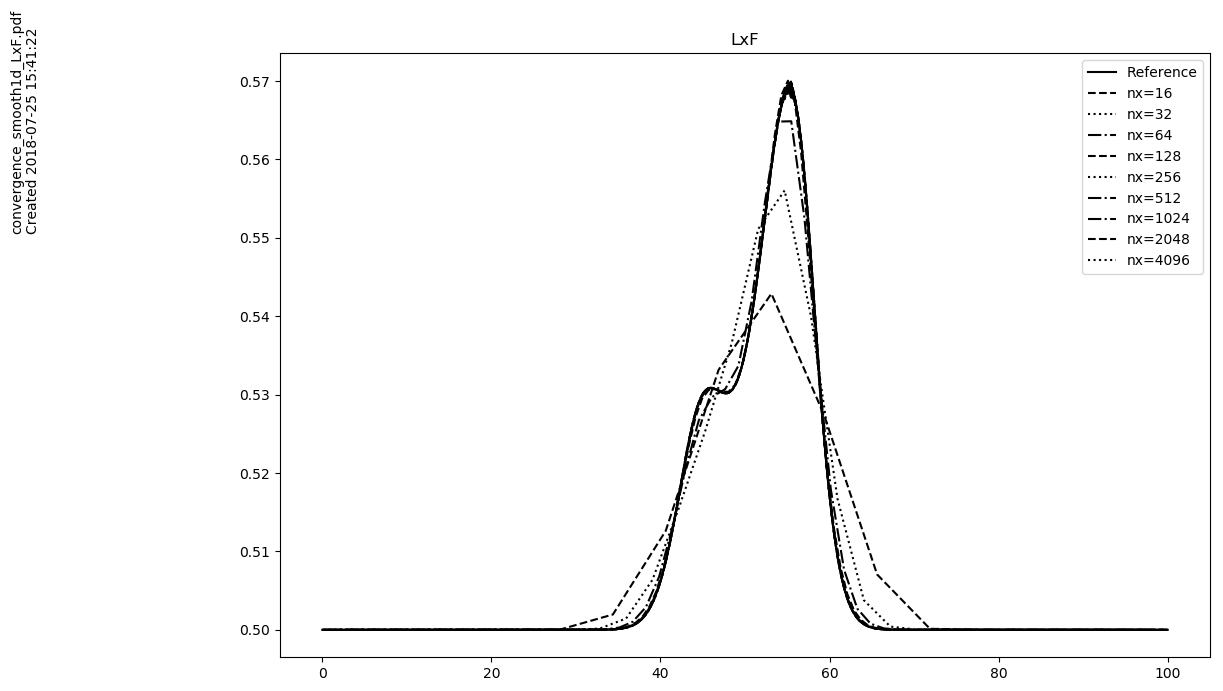

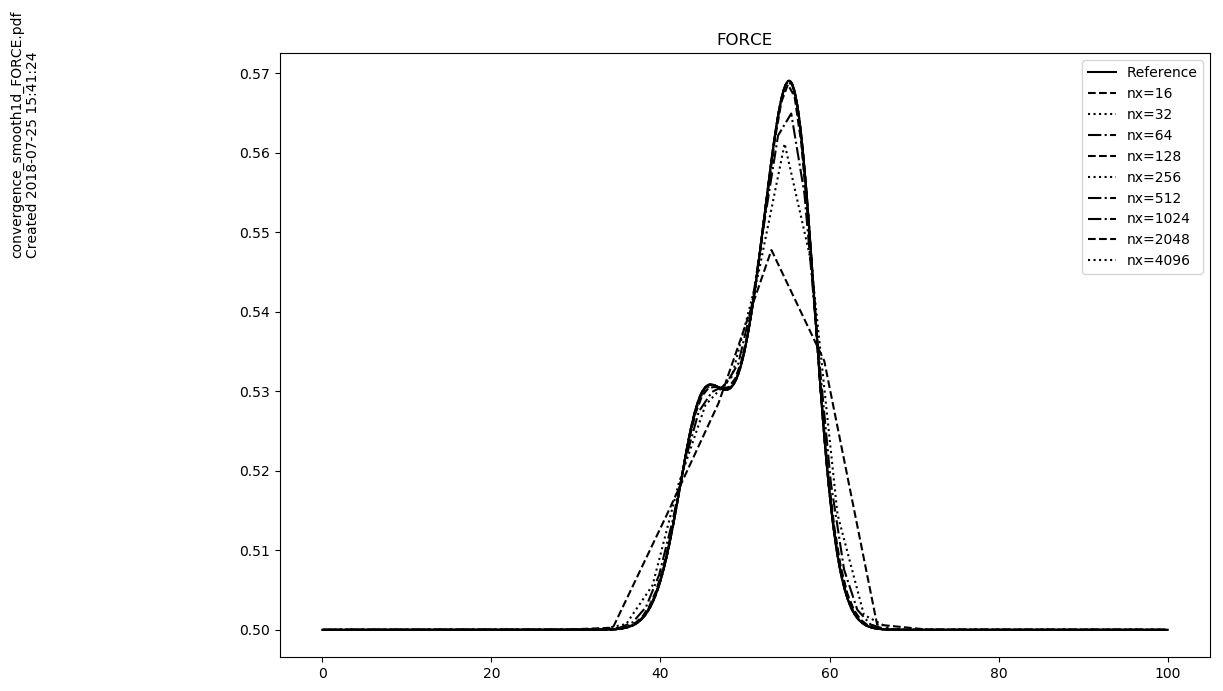

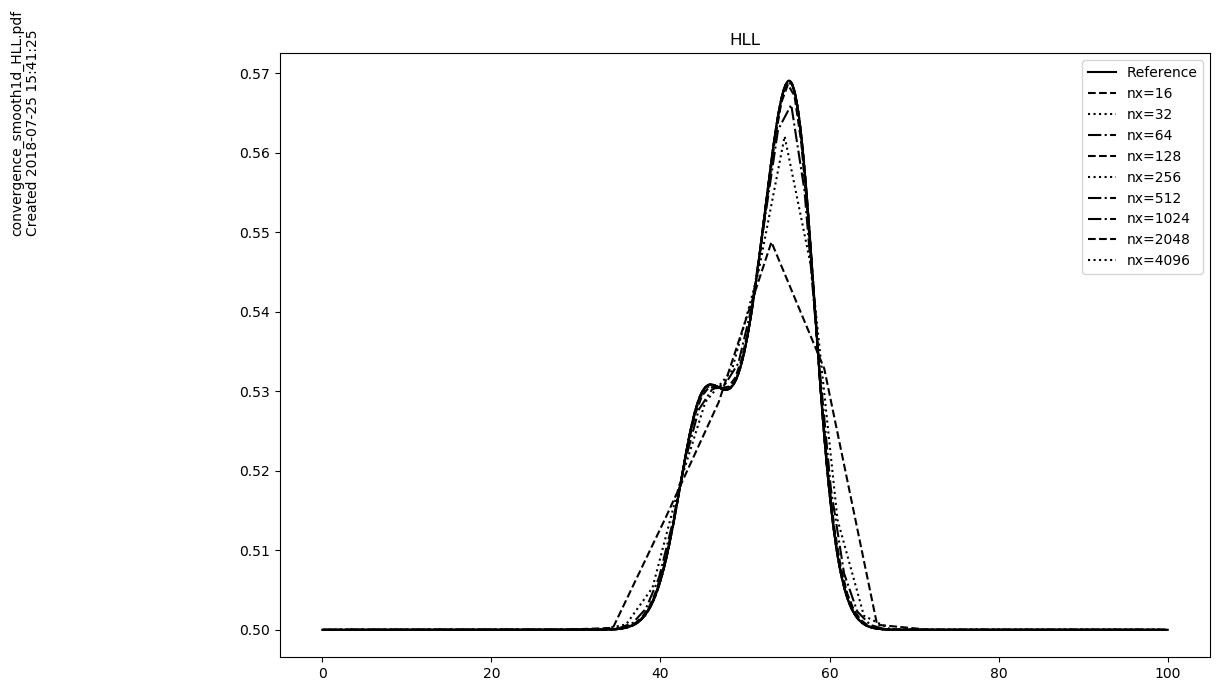

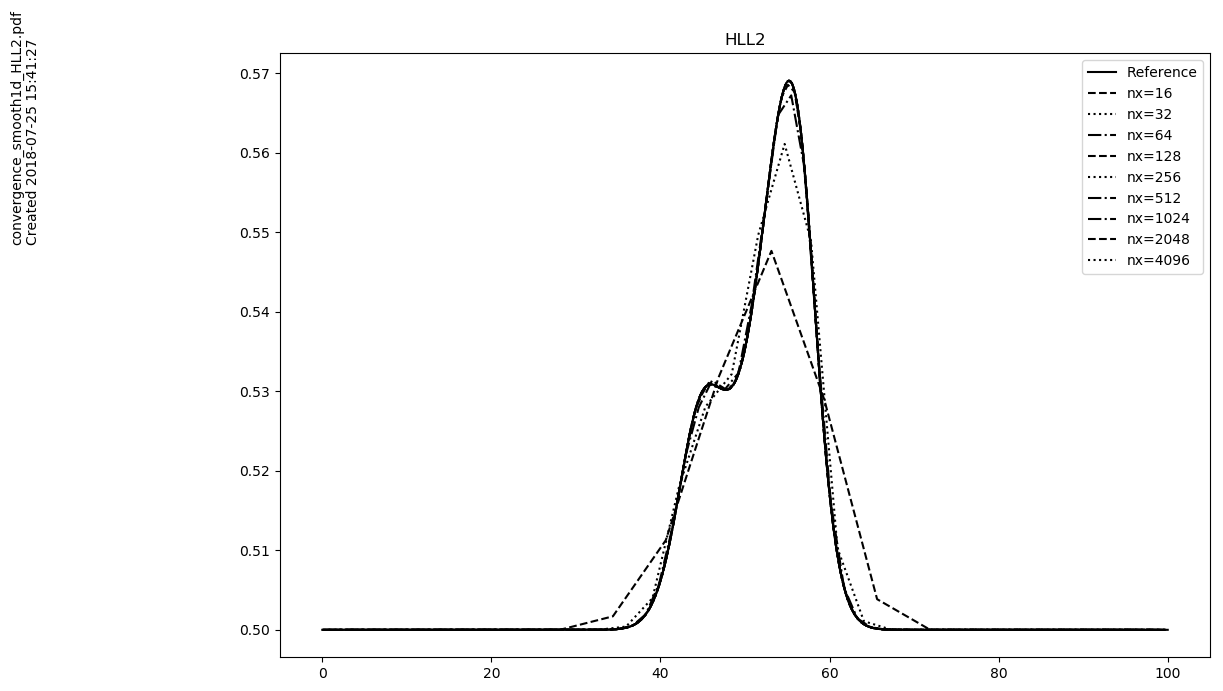

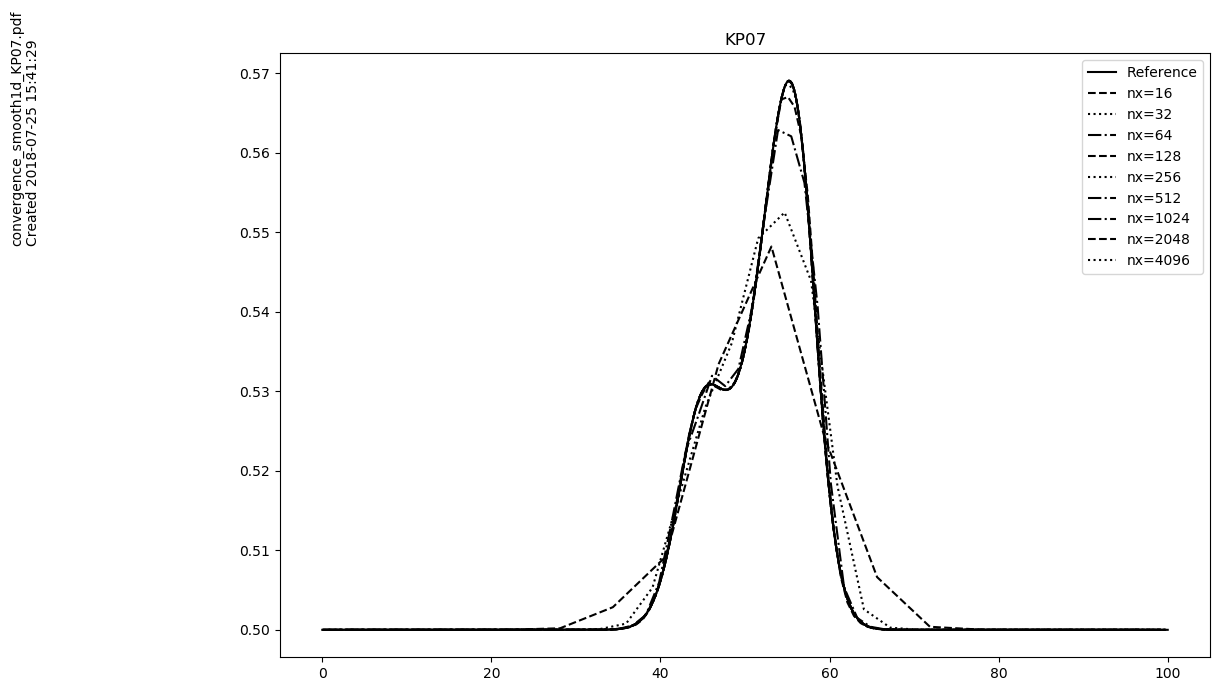

In [9]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
    
    plt.plot(x, h, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory

for simulator in simulators:
    fig = plt.figure()
    setBwStyles(fig.gca())
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
        
    plt.title(str(simulator.__name__))
    plt.legend()
    save_figure(fig, simulator.__name__)

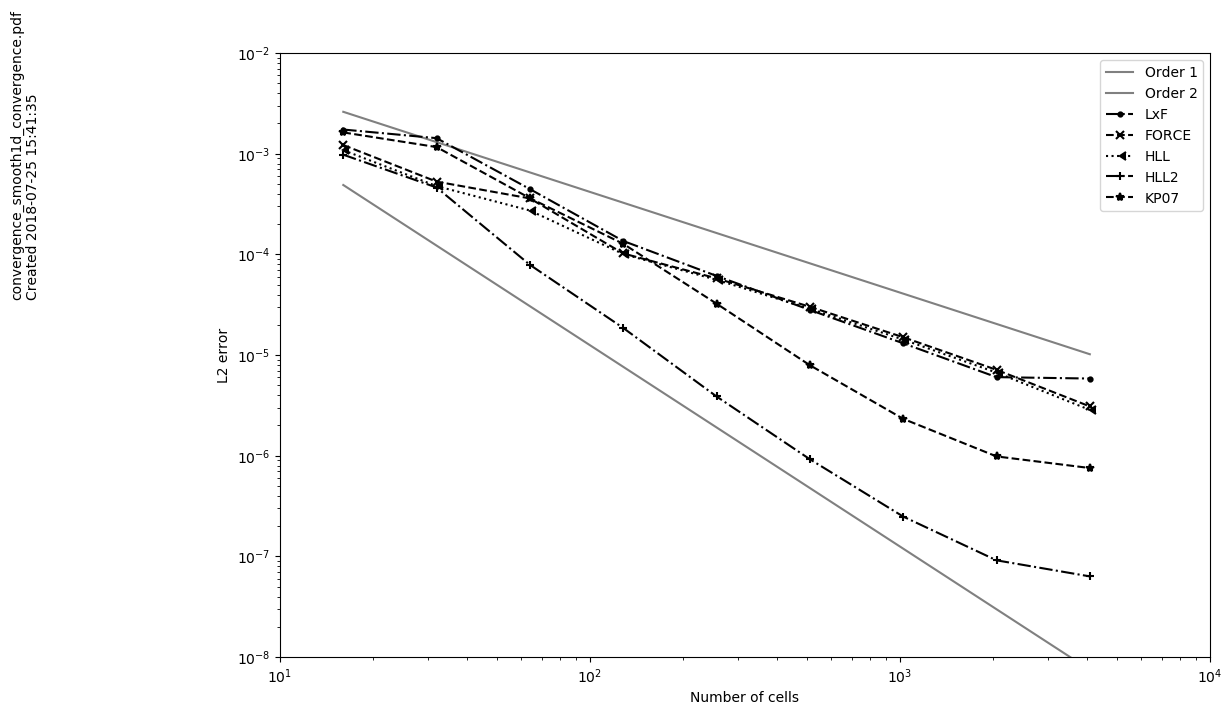

In [10]:
def downsample(highres_solution, factor):
    assert(highres_solution.size % factor == 0)
    nx = highres_solution.size / factor
    return highres_solution.reshape([int(nx), int(factor)]).mean(1)

conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))

for i, simulator in enumerate(simulators):
    #Read the reference solution
    datafilename = gen_filename(simulator, reference_nx)
    with np.load(datafilename) as data:
        h_ref = data['h']
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h']
        
        #Downsample reference to current resolution
        h_ref_downsampled = downsample(h_ref, reference_nx/nx)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm(np.abs(h_ref_downsampled - h), ord=1) / nx
        conservation[i, j] = (np.sum(h_ref_downsampled) - np.sum(h))
    
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)
    
plt.axis([10**1, 10**4, 10**-8, 10**-2])
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend()
save_figure(fig, 'convergence')

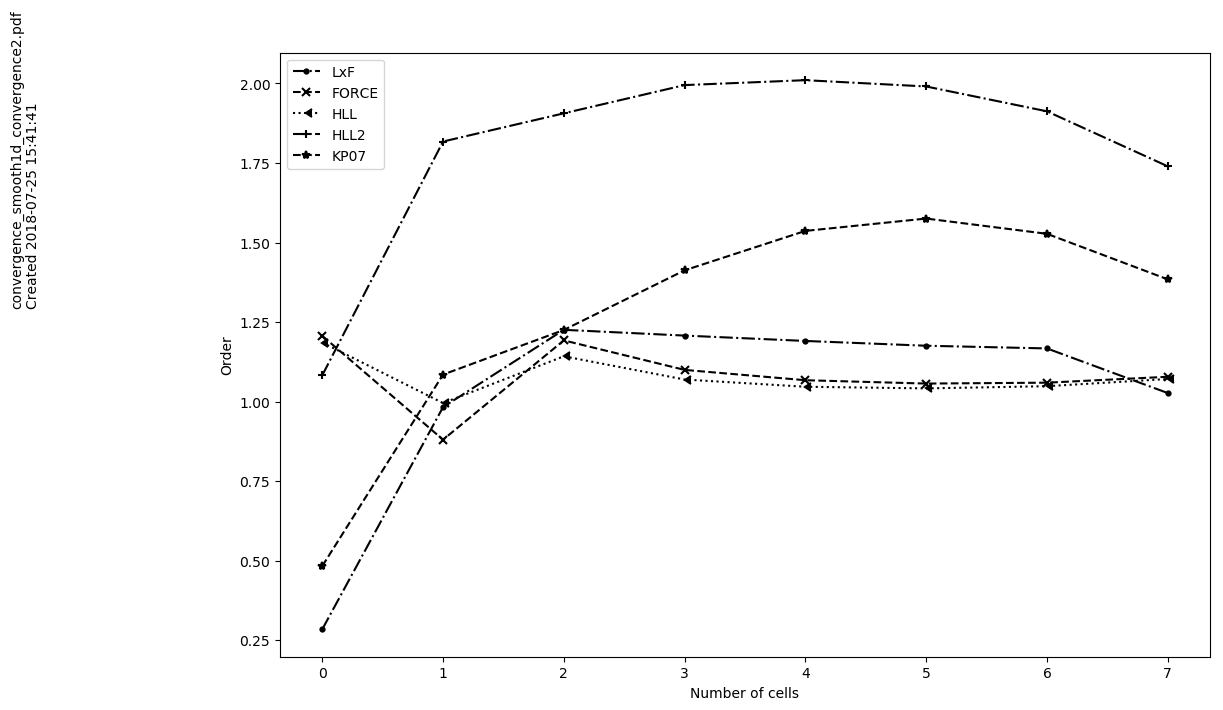

In [11]:
fig = plt.figure()
setBwStyles(fig.gca())

for i, simulator in enumerate(simulators):
    a = np.arange(1, len(domain_sizes))
    #order = np.log2(error[i, :-1] / error[i, 1:])
    order = np.log2(error[i, 0] / (error[i, 1:]) )/a
    plt.plot(order, label=simulator.__name__)
    
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend()
save_figure(fig, 'convergence2')


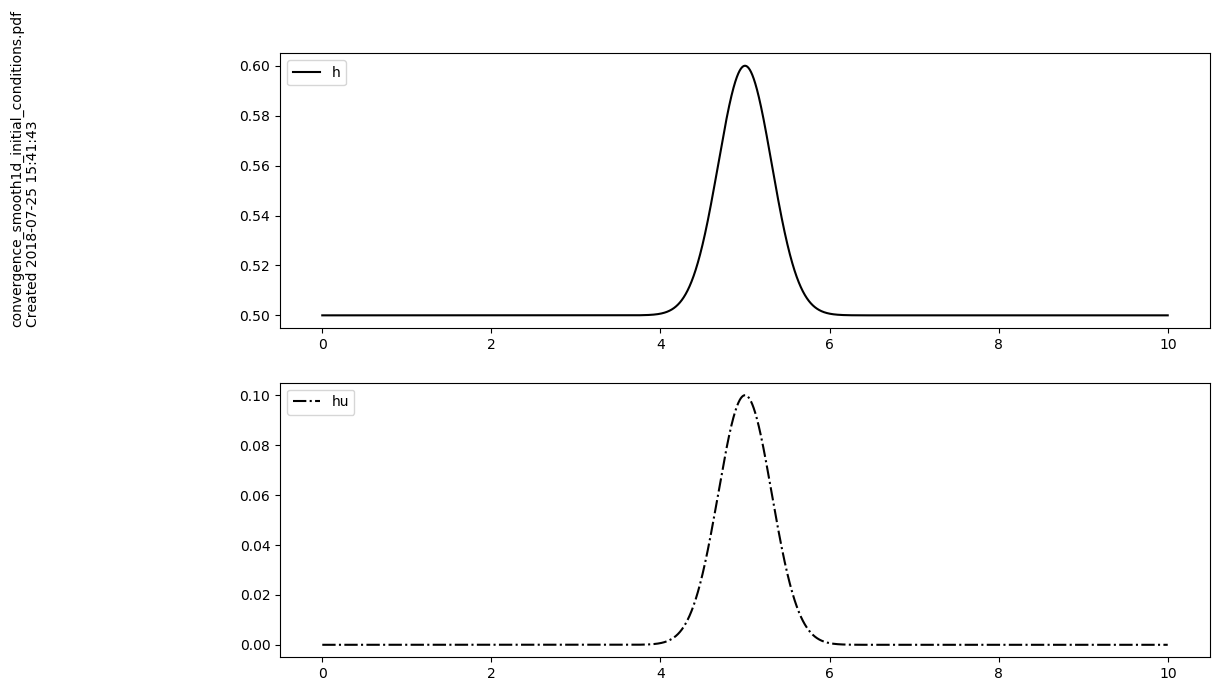

In [12]:
#Plot initial conditions            
fig = plt.figure()
reference_nx = 16384
ref_x = np.linspace(0.5, reference_nx-0.5, reference_nx)*10.0/float(reference_nx)
h0, hu0, hv0, dx, dy, dt, nx, ny = gen_test_data(reference_nx, 9.81, 0)
plt.subplot(211)
setBwStyles(fig.gca())
plt.plot(ref_x, h0.T, linestyle='-', marker=" ", label='h')
plt.legend(loc='upper left')
plt.subplot(212)
setBwStyles(fig.gca())
plt.plot(ref_x, hu0.T, linestyle='-.', marker=" ", label='hu')
plt.legend(loc='upper left')

save_figure(fig, 'initial_conditions')

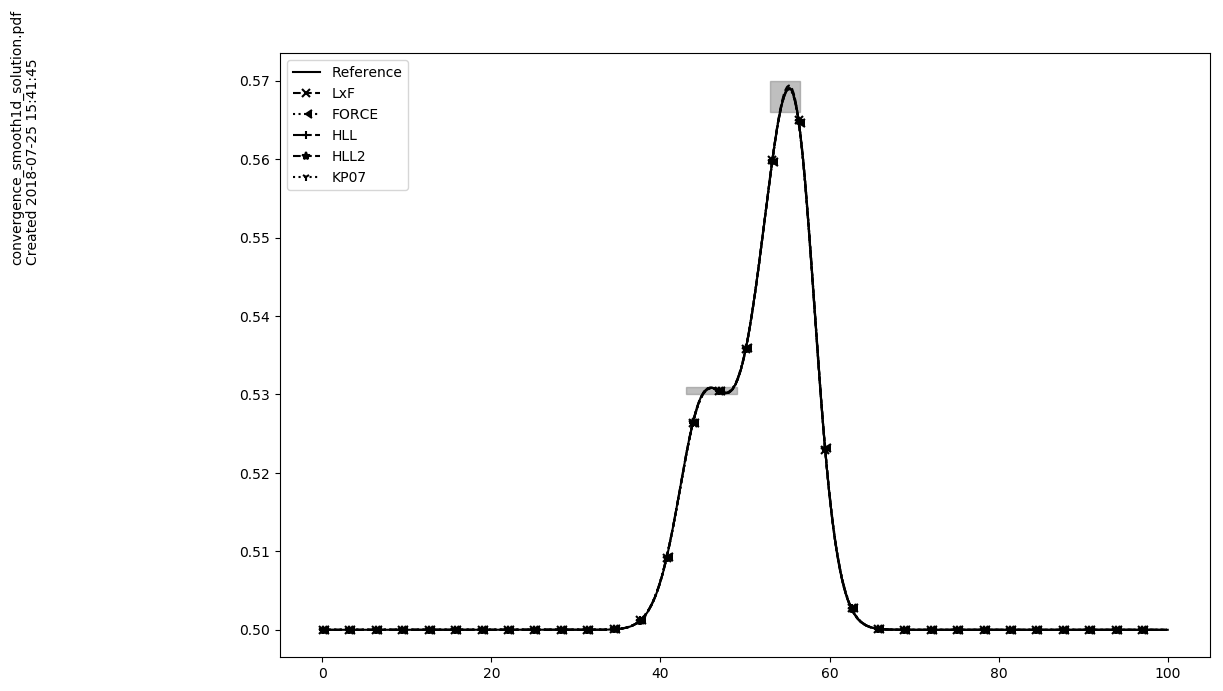

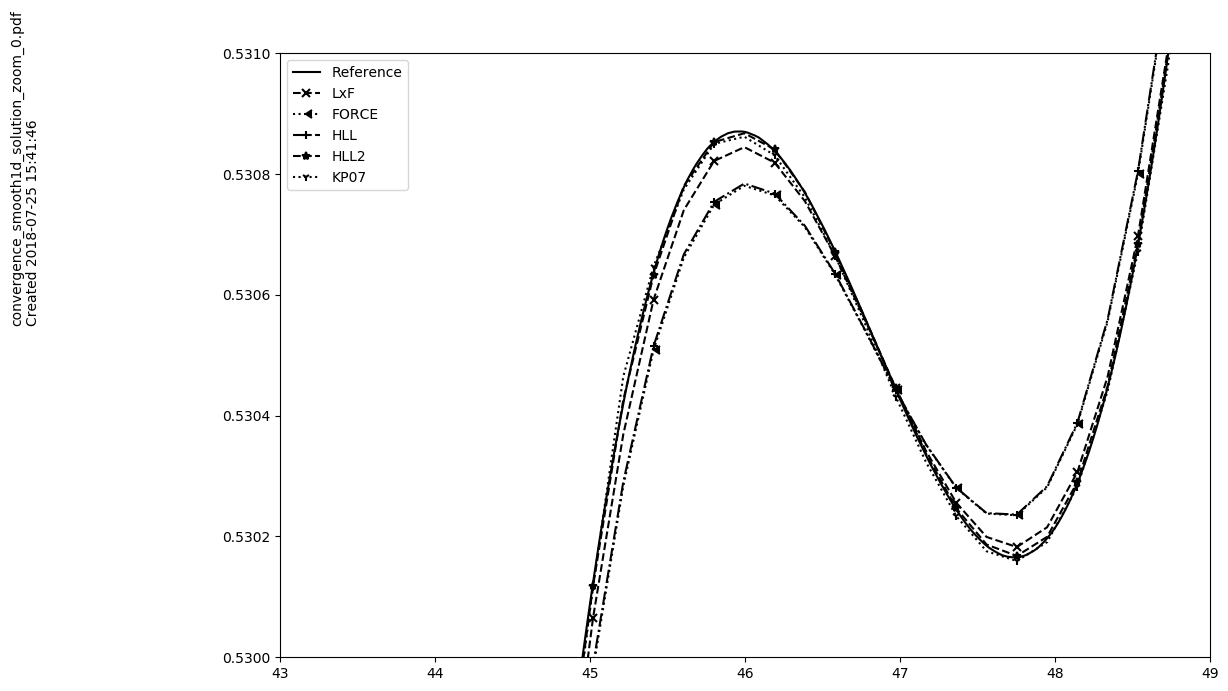

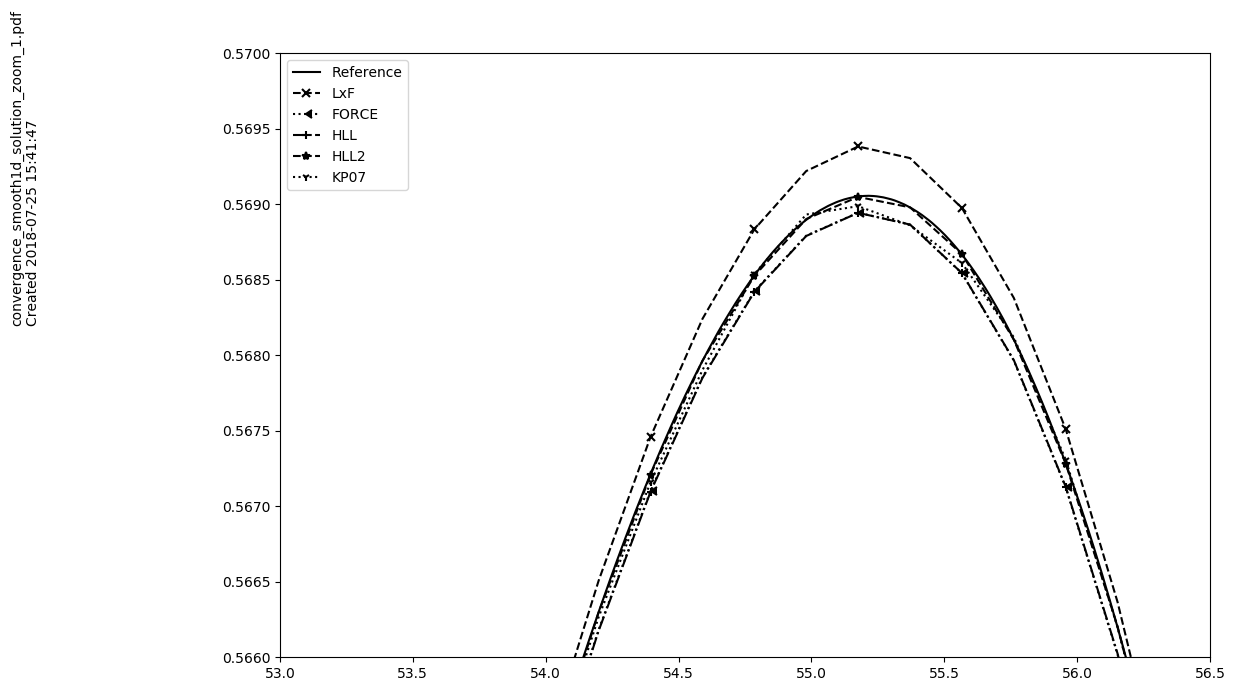

In [13]:
def plot_comparison(**kwargs):
    plot_solution(HLL2.HLL2, reference_nx, 'Reference', marker=' ', linestyle='-')

    for i, simulator in enumerate(simulators):
        nx = 512
        plot_solution(simulator, nx, simulator.__name__, **kwargs)


fig = plt.figure()
setBwStyles(fig.gca())

boxes = np.array([\
         [[43, 49], [0.53, 0.531]], \
         [[53, 56.5], [0.566, 0.57]]
         ])


plot_comparison(markevery=16)


for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
#plt.xlim([0, 10])
#plt.ylim([0, 0.0055])
plt.legend(loc='upper left')
save_figure(fig, 'solution')

for i, bbox in enumerate(boxes):
    fig = plt.figure()
    setBwStyles(fig.gca())
    plot_comparison(markevery=2)
    plt.xlim(bbox[0])
    plt.ylim(bbox[1])
    plt.legend(loc='upper left')
    
    save_figure(fig, "solution_zoom_" + str(i))